# Assignment IHE Hydrology, Transient Groundwater 2024

Prof. dr.ir. T.N.Olsthoorn 
Feb 18, 2024

# Groundnwater Basin bahavior


Get the recharge minus evaporation. We use historic data from [weather station De Bilt (KNMI Station 260)](https://www.knmi.nl/nederland-nu/klimatologie/daggegevens).

The data file `etmgeg_260.txt` are essentially a csv file with a number of explaining text lines at teh top, then the explanation of the headers, a line with the column headers, after which the data follow. This is the [screenshot of data file](./images/screenshotKNMIfile.jpg)

In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [4]:
IHE24 = '/Users/Theo/Entiteiten/IHE/IHE2023-2024/'
ASSIGN = os.path.join(IHE24, 'Assignment')
DATA = os.path.join(ASSIGN, 'data')
IMAG = os.path.join(ASSIGN, 'images')

for d in [IHE24, ASSIGN, DATA, IMAG]:
    assert os.path.isdir(d), 'Directory <{}> not found!'.format(d)

In [7]:
fname = '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/data/etmgeg_260.txt'
assert os.path.isfile(fname), "can't find file {}".format(fname)

In [81]:
with open(fname, 'r') as fp:
    i = 0
    while True:
        t = fp.readline()
        if t.startswith('#'):
            header = [tok.strip() for tok in t.split(',')]
            header[0] = header[0].replace('# ','')
            break
        else:
            i += 1

usecols = ['YYYYMMDD', 'TX', 'TN', 'TG', 'SQ', 'RH', 'EV24']
dtype = {'YYYYMMDD': str, 'TX': float, 'TN': float, 'TG': float, 'SQ': float, 'RH': float, 'EV24': float}
weather = pd.read_csv(fname, header=50, sep=',', index_col=0, dtype=dtype, usecols=usecols, skipinitialspace=True)
weather. index = [np.datetime64('{}-{}-{}'.format(p[:4], p[4:6], p[6:])) for p in weather.index]

weather.loc[weather['RH'] < 0, 'RH'] = 0.025
weather.loc[:, usecols[1:]] /= 10



### Plot the recharge and the evaporation

This reveals that we only have evaporation data > 1960. So we will later on only use those data.

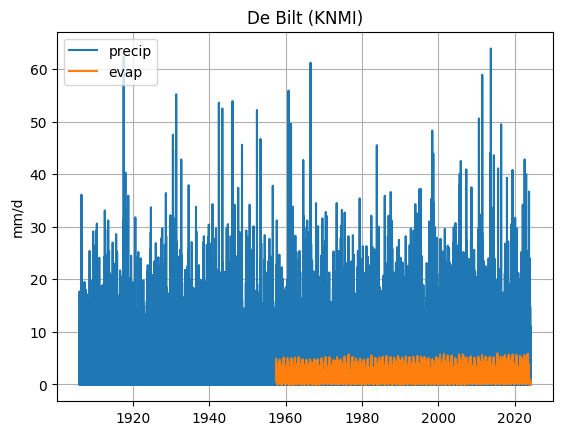

In [84]:
plt.plot(weather['RH'], label='precip')
plt.plot(weather['EV24'], label='evap')
plt.grid(True)
plt.title("De Bilt (KNMI)")
plt.ylabel("mm/d")
plt.legend()
plt.show()

### Plot the max and min temperature

This reveals that climate is getting warmer over time.

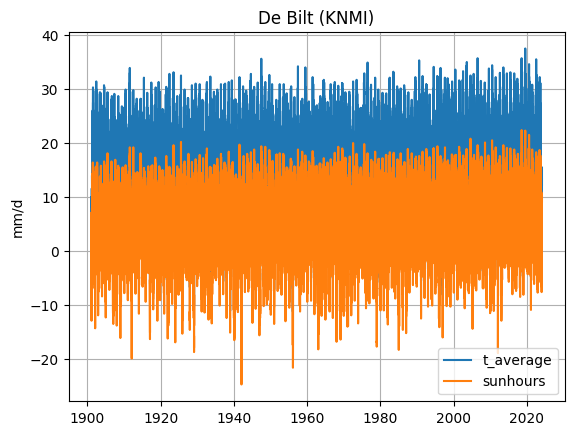

In [85]:
plt.plot(weather['TX'], label='t_average')
plt.plot(weather['TN'], label='sunhours')
plt.grid(True)
plt.title("De Bilt (KNMI)")
plt.ylabel("mm/d")
plt.legend()
plt.show()

## Print extreme values in our data set to get an idea of the values

In [86]:
print("EV24 max={:.3g}, mean={:.3g}, RH: max={:.3g} mean={:.3g}, TG: max={:.3g} mean={:.3g} min={:.3g}, SQ: max={:.3g}".format(
    weather['EV24'].max(),
    weather['EV24'].mean(),
    weather['RH'].max(),
    weather['RH'].mean(),
    weather['TG'].max(),
    weather['TG'].mean(),
    weather['TG'].min(),
    weather['SQ'].max()
))

EV24 max=5.9, mean=1.53, RH: max=63.9 mean=2.2, TG: max=29.7 mean=9.58 min=-14.9, SQ: max=16.7


In [126]:
recharge = weather.loc[weather.index > np.datetime64('1960-01-01'), ['RH', 'EV24']]

# Replace the NaNs
recharge.fillna({'RH': 0, 'EV24': recharge['EV24'].mean()}, inplace=True)
recharge = recharge['RH'] - recharge['EV24']
recharge /= 1000. # now in m/d

In [127]:
# Verify that all days are present:
tsteps = np.diff(recharge.index) / np.timedelta64(1, 'D')
np.all(tsteps==1.0)

True

# Simulation using convlution (i.e using scipy.signal.lfilter(b, a, x)

The head change in the system after a suddend recharge r is uniform and equal to dh = r / sy [mm] or [m] when r in mm/d or m/d

The head over time is then

$$s(x,t) = A \frac{4}{\pi}\sum_{j=1}^\infty\left\{\frac{(-1)^{j-1}}{2j-1}\cos\left[(2j-1)\left(\frac \pi 2\right)\frac x b \right]
\exp\left[-(2j-1)^2\left(\frac{\pi}{2}\right)^2\frac{t}{T}\right]\right\},\,\,\,\,T = \frac{b^2 S}{kD}$$
```
s(x,t) e ^{-ax}
```

In [123]:
def block_resp_basin(x=None, tau=None, b=None, kD=None, S=None, jmax=100):
    s = np.zeros_like(tau)
    T = b ** 2 * S / kD
    for j in range(1, jmax):
        tjm1 = 2 * j - 1
        s += (-1) ** (j - 1) / tjm1 * np.cos(tjm1 * (np.pi / 2) * (x / b)) * np.exp(-(tjm1 ** 2) * (np.pi / 2) ** 2 * tau / T)
    return s * 4  / np.pi / S


In [121]:
kD, S, b = 1500, 0.2, 8000
tau = (recharge.index - recharge.index[0]) / np.timedelta64(1, 'D')
print("T = {:.1f} y".format(b ** 2 * S / kD / 365))
print("tau [d] = ", tau)

T = 23.4 y
tau [d] =  Index([    0.0,     1.0,     2.0,     3.0,     4.0,     5.0,     6.0,     7.0,
           8.0,     9.0,
       ...
       23413.0, 23414.0, 23415.0, 23416.0, 23417.0, 23418.0, 23419.0, 23420.0,
       23421.0, 23422.0],
      dtype='float64', length=23423)


In [124]:
BR = block_resp_basin(x=0, tau=tau, b=b, kD=kD, S=S)
BR

array([5.01607585, 5.00000019, 5.        , ..., 0.00729288, 0.00729077,
       0.00728866])

In [147]:
h = lfilter(recharge, 1, BR)
rch2 = recharge.copy()
rch2[np.logical_and(rch2.index > np.datetime64('1980-01-01'), rch2.index < np.datetime64('2005-01-01'))] = 0

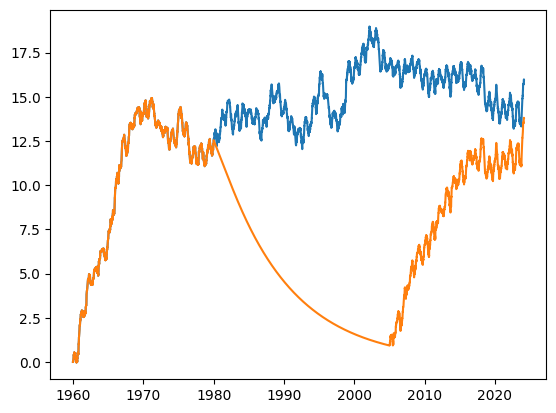

In [148]:
plt.plot(recharge.index, h)
plt.plot(rch2.index, lfilter(rch2, 1, BR))